In [1]:
# Setup and Data Loading


# Core libraries
# Data utilities
from functools import partial

import healpy as hp

# JAX ecosystem
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
from furax import HomothetyOperator
from furax.obs import negative_log_likelihood, sky_signal
from furax.obs.stokes import Stokes
from furax_cs import kmeans_clusters, minimize
from furax_cs.data import (
    get_mask,
    load_cmb_map,
    load_fg_map,
    load_from_cache,
    save_cmb_map,
    save_to_cache,
)

# JAX-HEALPix for clustering and sky operations
from jax_healpy.clustering import (
    get_cutout_from_mask,
    get_fullmap_from_cutout,
)

W0115 10:52:25.763282   18622 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0115 10:52:25.766156   18513 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [ ]:
# Configure JAX
jax.config.update("jax_enable_x64", True)

r_tensor_to_scalar_ratio = 3
# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2
noise_id = 0
noise_ratio = 1.0
tag = f"cr{r_tensor_to_scalar_ratio}d0s0"
mask_name = "ALL"

In [3]:
# Generate and load multi-frequency data
save_to_cache(nside, sky=tag)
save_cmb_map(nside, sky=tag)
nu, freq_maps = load_from_cache(nside, sky=tag)
_, fg_maps = load_fg_map(nside, sky=tag)
cmb_map = load_cmb_map(nside, sky=tag)

print(f"Frequency maps shape: {freq_maps.shape}")
print(f"Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX format (Q,U polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])
fg_stokes = Stokes.from_stokes(fg_maps[:, 1], fg_maps[:, 2])
cmb_map_stokes = Stokes.from_stokes(cmb_map[1], cmb_map[2])

# Load galactic mask (cleanest 20% of sky)
mask = get_mask(mask_name, nside=nside)
(indices,) = jnp.where(mask == 1)
coverage = jnp.mean(mask) * 100
print(f"Sky coverage: {coverage:.1f}% ({len(indices):,} pixels)")

# Extract masked data for computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
masked_fg = get_cutout_from_mask(fg_stokes, indices, axis=1)
masked_cmb = get_cutout_from_mask(cmb_map_stokes, indices)
print(f"Masked data shape: {masked_d.shape}")

[INFO] Detected custom r tag: cr3
[INFO] Generating custom CMB with r=0.003
[INFO] generating with r_value 0.003
[INFO] Added custom CMB with r=0.003 to maps.
✓ Generated and saved freq_maps for nside 64.
[INFO] Generating CMB map for nside 64, sky cr3d0s0
[INFO] generating with r_value 0.003
✓ Generated and saved freq_maps for nside 64 and for tag cr3.
[INFO] Loaded freq_maps for nside 64 from cache.
[INFO] Loaded freq_maps for nside 64 from cache.
[INFO] Loaded freq_maps for nside 64 from cache.
Frequency maps shape: (15, 3, 49152)
Frequencies: 15 bands from 40 to 402 GHz
Sky coverage: 100.0% (49,152 pixels)
Masked data shape: (15, 49152)


Generating spherical K-means clusters...
Clustering complete!


/tmp/ipykernel_18513/2273663576.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


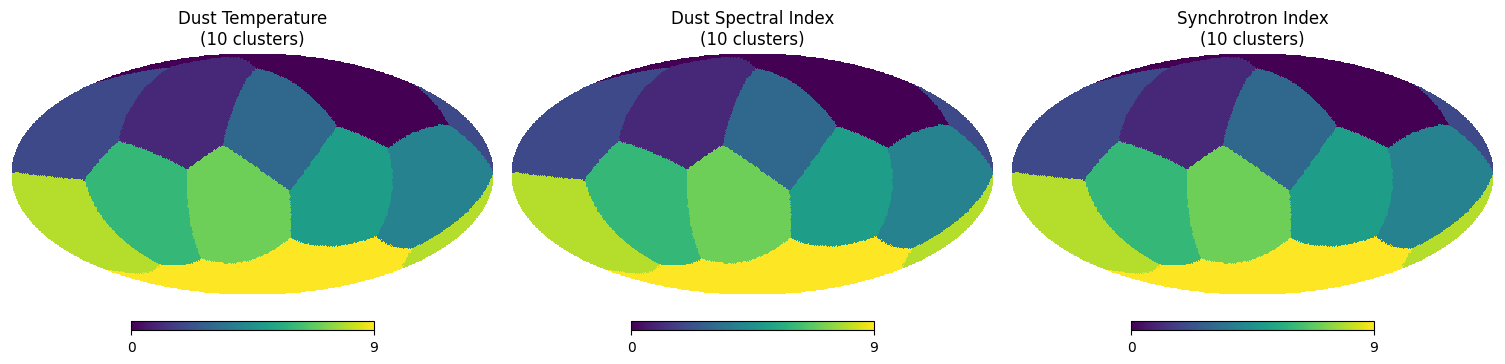

Masked clusters ready for optimization


In [4]:
# Spherical K-means Clustering
# Configure clustering parameters for different spectral indices
cluster_config = {
    "temp_dust": 10,  # Dust temperature clusters
    "beta_dust": 10,  # Dust spectral index clusters
    "beta_pl": 10,  # Synchrotron spectral index clusters
}
cluster_config = jax.tree.map(lambda x: min(indices.size, x), cluster_config)

# Generate clusters for each parameter type
print("Generating spherical K-means clusters...")
# Generate spherical K-means clusters on unmasked pixels
cluster_map = kmeans_clusters(jax.random.key(0), mask, indices, cluster_config, cluster_config)
cluster_map = {f"{param}_patches": patches for param, patches in cluster_map.items()}

print("Clustering complete!")

# Visualize the clustering results
fig = plt.figure(figsize=(15, 5))

param_labels = ["Dust Temperature", "Dust Spectral Index", "Synchrotron Index"]
for i, (param, label) in enumerate(zip(cluster_config.keys(), param_labels)):
    cluster_data = cluster_map[f"{param}_patches"]
    n_unique = jnp.unique(cluster_data[cluster_data != hp.UNSEEN]).size

    hp.mollview(
        cluster_data,
        title=f"{label}\n({n_unique} clusters)",
        sub=(1, 3, i + 1),
        bgcolor=(0.0,) * 4,
    )

plt.tight_layout()
plt.show()

# Extract masked clusters for optimization
masked_clusters = get_cutout_from_mask(cluster_map, indices)
masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int64), masked_clusters)
print("Masked clusters ready for optimization")

In [5]:
# Parameter Optimization

# Setup optimization parameters
dust_nu0 = 160.0  # Dust reference frequency (GHz)
synchrotron_nu0 = 20.0  # Synchrotron reference frequency (GHz)

# Create objective function with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
    analytical_gradient=True,
)

sky_signal_fn = partial(sky_signal, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0)

# Initialize parameters for each resolution level (realistic starting values)
base_params = {
    "beta_dust": 1.54,  # Dust spectral index
    "temp_dust": 20.0,  # 20K dust temperature
    "beta_pl": -3.0,  # Synchrotron index
}
initial_params = jax.tree.map(lambda v, c: jnp.full((c,), v), base_params, cluster_config)

print("Parameter initialization:")
for param, values in initial_params.items():
    print(f"  {param}: {len(values)} patches at resolution, initial value = {values[0]}")

# Create noise operator (simplified for demonstration)
N = HomothetyOperator(jnp.ones(1), _in_structure=masked_d.structure)

Parameter initialization:
  beta_dust: 10 patches at resolution, initial value = 1.54
  beta_pl: 10 patches at resolution, initial value = -3.0
  temp_dust: 10 patches at resolution, initial value = 20.0


In [6]:
print("\nRunning multi-resolution optimization...")
print("This may take a few minutes...")
# Run optimization using unified minimize API
final_params, final_state = minimize(
    fn=negative_log_likelihood_fn,
    init_params=initial_params,
    solver_name="optax_lbfgs",
    max_iter=1000,
    rtol=1e-10,
    atol=1e-8,
    nu=nu,
    N=N,
    d=masked_d,
    patch_indices=masked_clusters,
)

# Show optimization results
print("\nOptimization completed!")
print(f"Final function value: {final_state.state.best_loss:.2e}")


Running multi-resolution optimization...
This may take a few minutes...


100.00%|██████████| [00:00<00:00, 138.32%/s]


Optimization completed!
Final function value: -1.27e+10


In [7]:
# Compute CMB reconstruction with optimized parameters
reconstructed_signal = sky_signal_fn(
    final_params, nu=nu, d=masked_d, N=N, patch_indices=masked_clusters
)
cmb_reconstruction_masked = reconstructed_signal["cmb"]
cmb_reconstruction = get_fullmap_from_cutout(cmb_reconstruction_masked, indices, nside)
print("\nCMB reconstruction completed")
print(f"CMB shape: Q={cmb_reconstruction.q.shape}, U={cmb_reconstruction.u.shape}")


CMB reconstruction completed
CMB shape: Q=(49152,), U=(49152,)


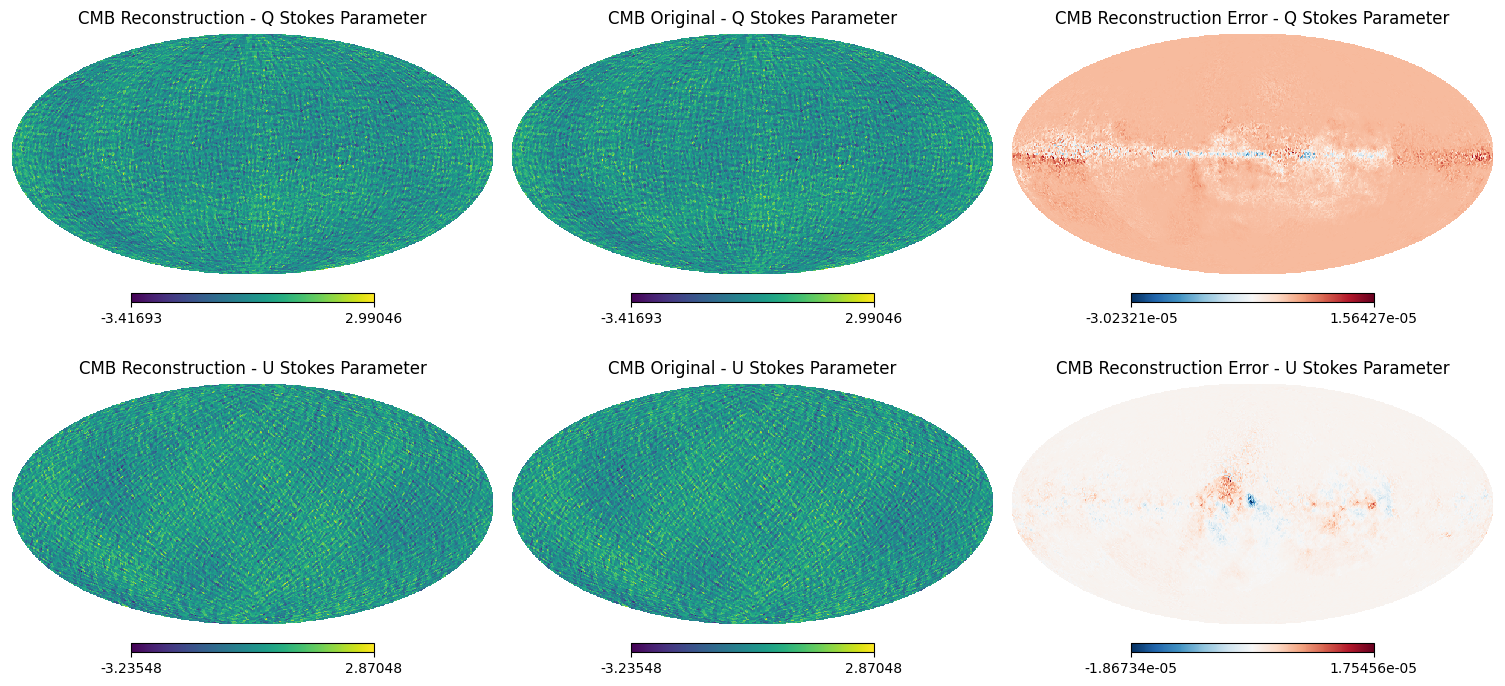

In [8]:
fig = plt.figure(figsize=(15, 7))

hp.mollview(
    cmb_reconstruction.q,
    title="CMB Reconstruction - Q Stokes Parameter",
    sub=(2, 3, 1),
    bgcolor=(0.0,) * 4,
)
hp.mollview(
    cmb_map[1],
    title="CMB Original - Q Stokes Parameter",
    sub=(2, 3, 2),
    bgcolor=(0.0,) * 4,
)
hp.mollview(
    cmb_reconstruction.q - cmb_map[1],
    title="CMB Reconstruction Error - Q Stokes Parameter",
    cmap="RdBu_r",
    sub=(2, 3, 3),
    bgcolor=(0.0,) * 4,
)
hp.mollview(
    cmb_reconstruction.u,
    title="CMB Reconstruction - U Stokes Parameter",
    sub=(2, 3, 4),
    bgcolor=(0.0,) * 4,
)
hp.mollview(
    cmb_map[2],
    title="CMB Original - U Stokes Parameter",
    sub=(2, 3, 5),
    bgcolor=(0.0,) * 4,
)
hp.mollview(
    cmb_reconstruction.u - cmb_map[2],
    title="CMB Reconstruction Error - U Stokes Parameter",
    cmap="RdBu_r",
    sub=(2, 3, 6),
    bgcolor=(0.0,) * 4,
)

In [9]:
print("\nRunning multi-resolution optimization...")
print("This may take a few minutes...")
# Run optimization using unified minimize API
wd_finale_params, wd_finale_state = minimize(
    fn=negative_log_likelihood_fn,
    init_params=initial_params,
    solver_name="optax_lbfgs",
    max_iter=1000,
    rtol=1e-10,
    atol=1e-8,
    nu=nu,
    N=N,
    d=masked_fg,
    patch_indices=masked_clusters,
)

# Compute CMB reconstruction with optimized parameters
reconstructed_wd_signal = sky_signal_fn(
    wd_finale_params, nu=nu, d=masked_fg, N=N, patch_indices=masked_clusters
)
cmb_syst_masked = reconstructed_wd_signal["cmb"]
cmb_syst = get_fullmap_from_cutout(cmb_syst_masked, indices, nside)

# Show optimization results
print("\nOptimization completed!")
print(f"Final function value: {final_state.state.best_loss:.2e}")


Running multi-resolution optimization...
This may take a few minutes...


100.00%|██████████| [00:00<00:00, 133.53%/s]


Optimization completed!
Final function value: -1.27e+10


/tmp/ipykernel_18513/3405642573.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


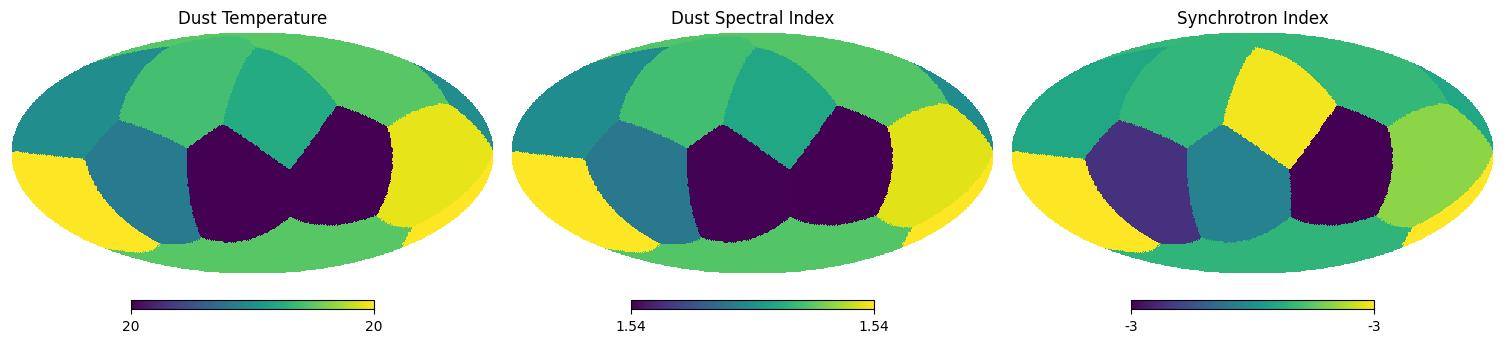

In [10]:
patches = {n.replace("_patches", ""): v for n, v in masked_clusters.items()}
params = jax.tree.map(lambda p, m: p[m], final_params, patches)
params = get_fullmap_from_cutout(params, indices, nside)

plt.figure(figsize=(15, 5))
param_names = ["temp_dust", "beta_dust", "beta_pl"]
param_labels = ["Dust Temperature", "Dust Spectral Index", "Synchrotron Index"]
for i, (param, label) in enumerate(zip(param_names, param_labels)):
    hp.mollview(
        params[param],
        title=label,
        sub=(1, 3, i + 1),
        bgcolor=(0.0,) * 4,
    )
plt.tight_layout()
plt.show()

[INFO] Mask detected: False, f_sky = 1.000, is_cl_obs = True


Computing residual spectra: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


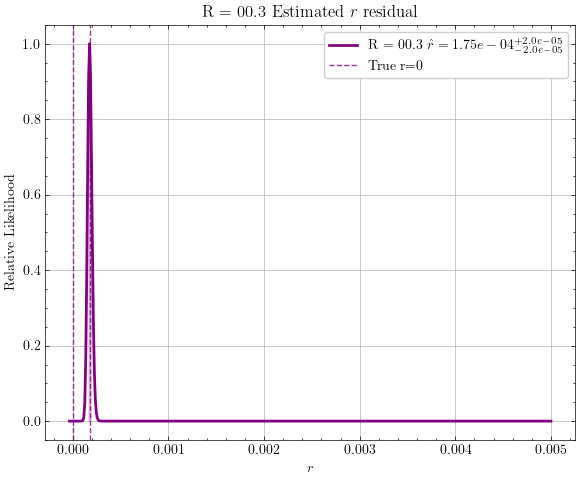

[INFO] Estimated r (Reconstructed): 1.7518e-04 (+2.0e-05, -2.0e-05)


In [11]:
from furax_cs.r_analysis import estimate_r_from_maps, plot_r_estimator

r_best, sigma_r_neg, sigma_r_pos, r_grid, L_vals, ell_range, cl_bb_r1, _, _ = estimate_r_from_maps(
    cmb_map_stokes, cmb_reconstruction, cmb_syst
)

plot_r_estimator("R = 00.3", r_best, sigma_r_neg, sigma_r_pos, r_grid, L_vals, output_format="show")